# Sample Philips Analysis

# Select Image & Phantom and Parse

In [1]:
imagePath = '/Volumes/CREST Data/David_S_Data/Philips SC 2D/V06_20180626_133351.rf'
phantomPath = '/Volumes/CREST Data/David_S_Data/Philips SC 2D/C3P11SED00_20180821_102323.rf'

In [2]:
dataFile = open(imagePath, 'rb')
dataSig = list(dataFile.read(8))
phantomFile = open(phantomPath, 'rb')
phantomSig = list(phantomFile.read(8))

In [3]:
# Assert inputted data has Philips signature
assert dataSig == [0,0,0,0,255,255,0,0]
assert phantomSig == [0,0,0,0,255,255,0,0]

In [4]:
destImgFilePath = imagePath.replace('.rf', '.mat')
destPhantomFilePath = phantomPath.replace('.rf', '.mat')

In [5]:
from pyquantus.parse.philipsRf import philipsRfParser

imgShape = philipsRfParser(imagePath)
phantomShape = philipsRfParser(phantomPath)

Opening: /Volumes/CREST Data/David_S_Data/Philips SC 2D/V06_20180626_133351.rf
Header information found:
Parsing Fusion RF capture file ...
	File Version: 3
	Header Size: 892 bytes

Elapsed time is 0:00:26.729555 seconds.
Parsing header info ...
Elapsed time is 0:00:26.800118 seconds.
Parsing RF data ...
Elapsed time is 0:00:32.330349 seconds.
Organizing based on data type ...
	PostXBR
		Capture_ML:	16x

		Echo_ML:	4x

		CRE:	4

Elapsed time is 0:00:37.640173 seconds.
Done
Opening: /Volumes/CREST Data/David_S_Data/Philips SC 2D/C3P11SED00_20180821_102323.rf
Header information found:
Parsing Fusion RF capture file ...
	File Version: 3
	Header Size: 892 bytes

Elapsed time is 0:00:26.769719 seconds.
Parsing header info ...
Elapsed time is 0:00:26.858922 seconds.
Parsing RF data ...
Elapsed time is 0:00:33.991927 seconds.
Organizing based on data type ...
	PostAGNOS
		Capture_ML:	16x

		Echo_ML:	2x

Elapsed time is 0:00:37.637005 seconds.
Done


In [6]:
from pyquantus.parse.philipsMat import philips2dRfMatParser

imgDataStruct, imgInfoStruct, refDataStruct, refInfoStruct = philips2dRfMatParser(destImgFilePath, destPhantomFilePath, frame=0)

/Users/davidspector/miniconda3/envs/QuantUS-env/lib/python3.11/site-packages/pyquantus/parse/philipsMat.py:82: RuntimeWarning: divide by zero encountered in log10
  bmode[:,i] = 20*np.log10(abs(hilbert(echoData[:,i]))) # type: ignore
/Users/davidspector/miniconda3/envs/QuantUS-env/lib/python3.11/site-packages/pyquantus/parse/philipsMat.py:82: RuntimeWarning: invalid value encountered in cast
  bmode[:,i] = 20*np.log10(abs(hilbert(echoData[:,i]))) # type: ignore


# ROI Selection (from GUI)

In [7]:
import pickle

pkl_name = "/Volumes/CREST Data/David_S_Data/Philips SC 2D/roi.pkl"

with open(pkl_name, "rb") as f:
    roi_info = pickle.load(f)

In [8]:
from pathlib import Path

assert roi_info["Image Name"] == Path(destImgFilePath).name
assert roi_info["Phantom Name"] == Path(destPhantomFilePath).name

In [9]:
scSplineX = roi_info["Spline X"]
scSplineY = roi_info["Spline Y"]

# Analysis Config (from GUI)

In [10]:
from pyquantus.qus import AnalysisConfig

pkl_name = "/Volumes/CREST Data/David_S_Data/Philips SC 2D/analysis-config.pkl"

with open(pkl_name, "rb") as f:
    config_info = pickle.load(f)

In [11]:
config = config_info["Config"]

# Spectral Analysis

In [12]:
from pyquantus.qus import UltrasoundImage

ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfoStruct.depth / imgDataStruct.rf.shape[0]
ultrasoundImage.lateralResRf = ultrasoundImage.axialResRf * (
    imgDataStruct.rf.shape[0]/imgDataStruct.rf.shape[1]
) # placeholder
ultrasoundImage.bmode = imgDataStruct.scBmodeStruct.preScArr
ultrasoundImage.phantomRf = refDataStruct.rf
ultrasoundImage.rf = imgDataStruct.rf
ultrasoundImage.scBmode = imgDataStruct.scBmode
ultrasoundImage.xmap = imgDataStruct.scBmodeStruct.xmap
ultrasoundImage.ymap = imgDataStruct.scBmodeStruct.ymap

In [13]:
from pyquantus.qus import SpectralAnalysis

spectralAnalysis = SpectralAnalysis()
spectralAnalysis.ultrasoundImage = ultrasoundImage
spectralAnalysis.config = config
spectralAnalysis.initAnalysisConfig()
spectralAnalysis.scSplineX = scSplineX
spectralAnalysis.scSplineY = scSplineY

In [14]:
spectralAnalysis.splineToPreSc()
spectralAnalysis.generateRoiWindows()
spectralAnalysis.computeSpecWindows()

/Users/davidspector/miniconda3/envs/QuantUS-env/lib/python3.11/site-packages/pyquantus/qus/analysis.py:192: RuntimeWarning: divide by zero encountered in divide
  w = np.nanmean((r / p) ** 2, axis=1)
/Users/davidspector/miniconda3/envs/QuantUS-env/lib/python3.11/site-packages/pyquantus/qus/analysis.py:193: RuntimeWarning: divide by zero encountered in divide
  u = (w**2) / np.var((r / p) ** 2, axis=1)
/Users/davidspector/miniconda3/envs/QuantUS-env/lib/python3.11/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# Visualizations

In [16]:
from pyquantus.qus import SpectralData
from pyquantus.parse.objects import ScConfig

scConfig = ScConfig()
scConfig.width = imgInfoStruct.width1
scConfig.tilt = imgInfoStruct.tilt1
scConfig.startDepth = imgInfoStruct.startDepth1
scConfig.endDepth = imgInfoStruct.endDepth1

spectralData = SpectralData()
spectralData.spectralAnalysis = spectralAnalysis
spectralData.scConfig = scConfig

In [17]:
spectralData.convertImagesToRGB()

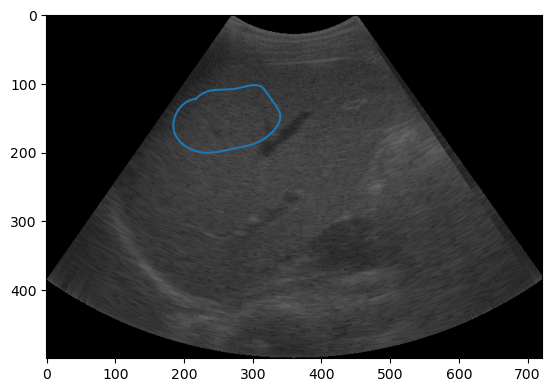

In [18]:
import matplotlib.pyplot as plt

plt.imshow(ultrasoundImage.scBmode)
plt.plot(scSplineX, scSplineY)

In [19]:
spectralData.drawCmaps()
spectralData.scanConvertCmaps()

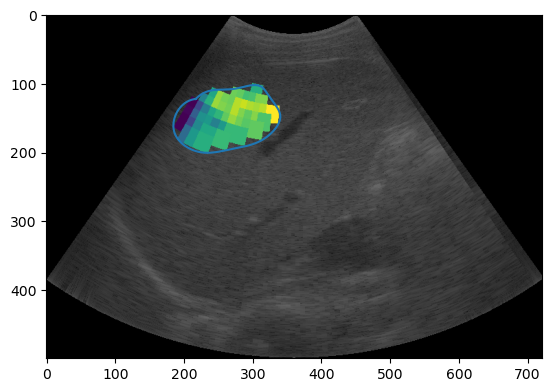

In [20]:
plt.imshow(spectralData.scMbfIm)
plt.plot(scSplineX, scSplineY)

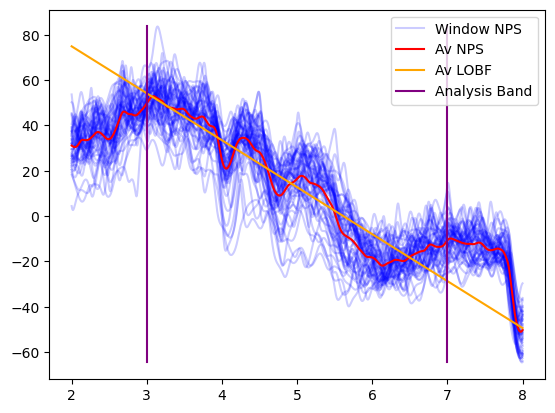

In [23]:
spectralData.plotPsData()

In [24]:
import numpy as np
np.mean(spectralData.mbfArr), np.mean(spectralData.siArr), np.mean(spectralData.ssArr)

(12.73425403100865, 116.40197215158264, -2.073101267396536e-05)